## The Tolman-Eichenbaum Machine: Unifying Space and Relational Memory through Generalization in the Hippocampal Formation
James C.R. Whittington, Timothy H. Muller, Shirley Mark, Guifen Chen, Caswell Barry, Neil Burgess, Timothy E.J. Behrens
https://doi.org/10.1016/j.cell.2020.10.024

In this notbook we provide and example of how to plot results of the Tolman-Eichenbaum Machine (TEM) model. Here we give example results from a pretrained model, however the model can be trained in a variety of environments from the [run file](./whittington_2020_run.py)

In [20]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from importlib import util
import neuralplayground.agents.whittington_2020_extras.whittington_2020_parameters as parameters
import neuralplayground.agents.whittington_2020_extras.whittington_2020_analyse as analyse
import neuralplayground.agents.whittington_2020_extras.whittington_2020_plot as plot

#### Select trained model
Choose the folder which contains the saved data from the trained TEM model.

In [21]:
pars_orig = parameters.parameters()
params = pars_orig.copy()

date = 'example'
run = '1'
model_path = os.path.abspath(os.pardir) + '/Summaries2/' + date + '/torch_run' + run + '/model/'
save_path = os.path.abspath(os.pardir) + '/Summaries2/' + date + '/torch_run' + run + '/save/'

#### Load variables
TEM model saves grid and place representations, as well as information on accuracy and zero-shot inference, at the end of training.

In [22]:
environments = torch.load(save_path + 'environments')
g = torch.load(save_path + 'g')
p = torch.load(save_path + 'p')
correct_model, correct_node, correct_edge = torch.load(save_path + 'correct_all')
zero_shot = torch.load(save_path + 'zero_shot')

#### Choose which environment to plot
For reasons of efficiency, only the trajectory of one environment (within a batch) is saved and can be loaded.

In [23]:
env_to_plot = 0
environment = environments[env_to_plot]
shiny_envs = [False for _ in range(16)]
envs_to_avg = shiny_envs if shiny_envs[env_to_plot] else [not shiny_env for shiny_env in shiny_envs]

#### Plot TEM prediction accuracy
The prediction accuracy of TEM is plotted for the final 5000 steps in training trajectory. This is plotted alongside the proportion of nodes and edges visitied.

Text(0.5, 1.0, 'Zero-shot inference: 26.454293628808866%')

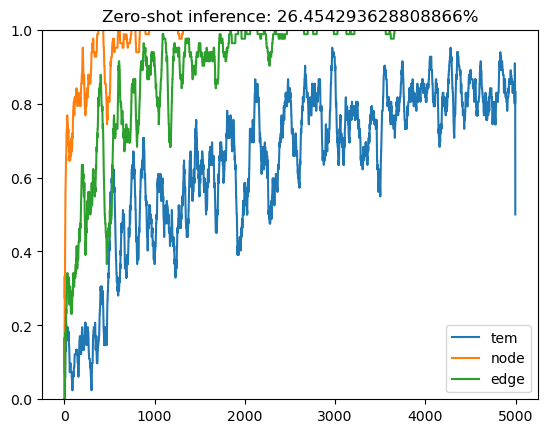

In [24]:
# Plot results of agent comparison and zero-shot inference analysis
filt_size = 41
plt.figure()
plt.plot(analyse.smooth(np.mean(np.array([env for env_i, env in enumerate(correct_model) if envs_to_avg[env_i]]),0)[1:], filt_size), label='tem')
plt.plot(analyse.smooth(np.mean(np.array([env for env_i, env in enumerate(correct_node) if envs_to_avg[env_i]]),0)[1:], filt_size), label='node')
plt.plot(analyse.smooth(np.mean(np.array([env for env_i, env in enumerate(correct_edge) if envs_to_avg[env_i]]),0)[1:], filt_size), label='edge')
plt.ylim(0, 1)
plt.legend()
plt.title('Zero-shot inference: ' + str(np.mean([np.mean(env) for env_i, env in enumerate(zero_shot) if envs_to_avg[env_i]]) * 100) + '%')

#### Plot all cells
Plot both hippocampal and entorhinal cells for all frequency modules.

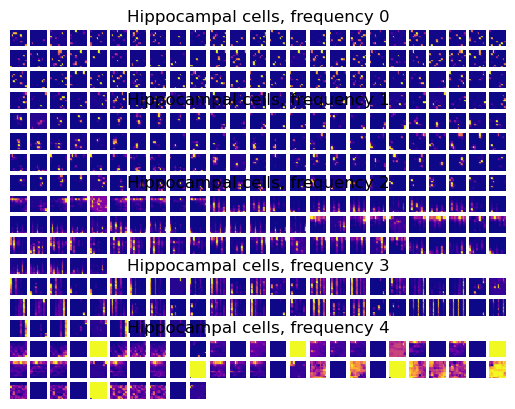

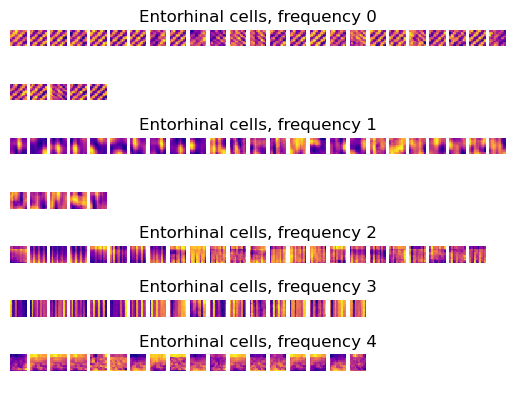

In [25]:
plot.plot_cells(p[env_to_plot], g[env_to_plot], environments[env_to_plot], n_f_ovc=(params['n_f_ovc'] if 'n_f_ovc' in params else 0), columns = 25)
plt.show()

#### Plot single cell
Plot hippocampal or entorhinal cells at a specific frequency module.

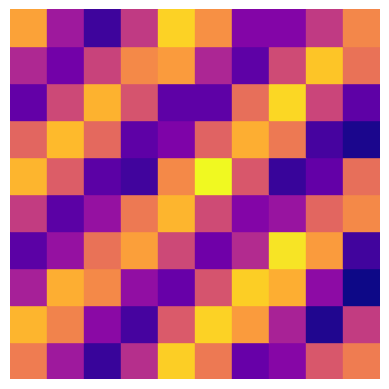

In [35]:
cells = g[env_to_plot]
# Get specific row and column
n_cell = 0
row = 0
col = 6
# Plot rate map for this cell by collection firing rate at each location
loc_rates = cells[n_cell]
plot.plot_map(environment, np.array([loc_rates[l][col] for l in range(len(loc_rates))]), shape='square')
plt.show()